In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2
%load_ext ipython_unittest

import numpy as np
import torch
import torch.nn.functional as F

import helper

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Today's Dataset: MNIST (Digit classification)

<img src='imgs/mnist.png'>

## Create and Explore MNIST Dataset

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

Total # of train images: 60000
Total # of test images: 10000
Image Shape: torch.Size([1, 28, 28])
Label: 5


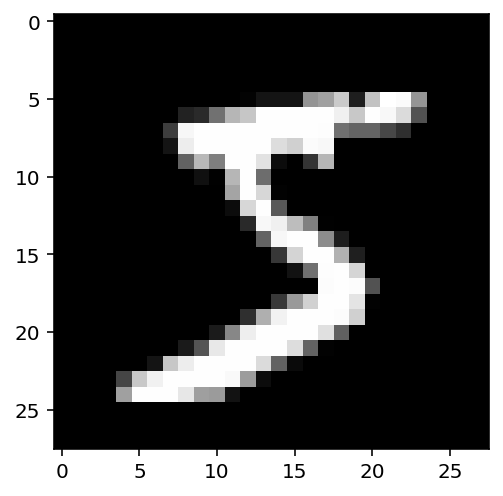

In [4]:
image, label = trainset[0]
print("Total # of train images: {}".format(len(trainset)))
print("Total # of test images: {}".format(len(valset)))
print("Image Shape: {}".format(image.size()))
print("Label: {}".format(label))
plt.imshow(image.numpy().squeeze(), cmap='Greys_r');

# Create a Linear Classifier

In [5]:
from torch import nn

### Exercise 1: Implement CustomLinear

In [6]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = nn.Parameter(torch.randn(in_features, out_features))
        self.b = nn.Parameter(torch.randn(out_features))
    
    def forward(self, inputs):
        return ?

In [7]:
%%unittest_main
import numpy as np

def create_random_targets(*shape):
    batch_size, num_class, H, W = shape
    eye = torch.eye(num_class)
    return eye[np.random.choice(num_class, batch_size * H * W)].view(batch_size, num_class, H, W)
    
def is_almost_equal(tens_a, tens_b, delta=1e-5):
    return torch.all(torch.lt(torch.abs(torch.add(tens_a, -tens_b)), delta))

class TestCustomLinearLayer(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.in_features = 5
        self.out_features = 10
        
    def test_layer_output_size(self):
        inputs = torch.randn((self.batch_size, self.in_features))
        fc = CustomLinear(self.in_features, self.out_features)
        
        outputs = fc(inputs)
        self.assertTupleEqual((self.batch_size, self.out_features), outputs.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Exercise 2: Implement a Linear Classifer using the CustomLinear

![](imgs/network_diagram.png)

In [8]:
class CustomLinearClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_class=10):
        super().__init__()
        self.input_size = input_size
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.fc2 = CustomLinear(hidden_size, num_class)
    
    def forward(self, inputs):
        flatten_inputs = ?
        o1 = ?
        logits = ?
        return logits

In [9]:
%%unittest_main
import numpy as np

class TestCustomLinearClassifier(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 10
        self.channel, self.height, self.width = 1, 28, 28
        
    def test_model_output_size(self):
        images = torch.randn(self.batch_size, self.channel, self.height, self.width)
        model = CustomLinearClassifier()
        
        outputs = model(images)
        self.assertTupleEqual((self.batch_size, self.num_class), outputs.size())


Success

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# We Don't need to wait. Let's Train it!

In [10]:
import copy
import time

from metric import AverageMeterSet


def print_metrics(phase, average_meter_set: AverageMeterSet):
    results = ["{}: {:4f}".format(k, v) for k, v in average_meter_set.averages().items()]
    print("{}: {}".format(phase, ", ".join(results)))


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()  # Set model to training mode
    average_meter_set = AverageMeterSet()
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        logits = model(inputs)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        average_meter_set.update('loss', loss.item())

    return average_meter_set, model


def validate(model, dataloader, device):
    model.eval()  # Set model to evaluate mode
    average_meter_set = AverageMeterSet()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            loss = criterion(logits, labels)
            
            _, preds = logits.max(1)
            average_meter_set.update('correct', preds.eq(labels).sum().item(), n=inputs.size(0))
            average_meter_set.update('loss', loss.item())

    return average_meter_set


def train_model(model, dataloaders, optimizer, device, num_epochs=25):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                average_meter_set, model = train_one_epoch(model, dataloaders[phase], optimizer, device)
                print_metrics(phase, average_meter_set)
                # lr_scheduler.step()
            else:
                average_meter_set = validate(model, dataloaders[phase], device)
                print_metrics(phase, average_meter_set)
                epoch_acc = average_meter_set.averages()['correct']

                if epoch_acc > best_acc:
                    print("Saving the Best Model")
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Create Trainloader

In [11]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

dataloaders = {
    'train': trainloader,
    'val': valloader
}

## Create Our Loss Function

In [12]:
criterion = nn.CrossEntropyLoss()

## Create a Model and a Optimizer

In [13]:
import torch.optim as optim
from torch.optim import lr_scheduler

custom_linear_model = CustomLinearClassifier()
optimizer_ft = optim.Adam(custom_linear_model.parameters(), lr=1e-3)
custom_linear_model = train_model(custom_linear_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 74.503100
val: correct: 0.828500, loss: 22.516309
Saving the Best Model
0m 11s
Epoch 1/9
----------
LR 0.001
train: loss: 20.336023
val: correct: 0.853700, loss: 16.500135
Saving the Best Model
0m 11s
Epoch 2/9
----------
LR 0.001
train: loss: 15.748947
val: correct: 0.865000, loss: 13.845797
Saving the Best Model
0m 11s
Epoch 3/9
----------
LR 0.001
train: loss: 13.285053
val: correct: 0.882200, loss: 11.228973
Saving the Best Model
0m 11s
Epoch 4/9
----------
LR 0.001
train: loss: 11.801427
val: correct: 0.869800, loss: 11.288218
0m 11s
Epoch 5/9
----------
LR 0.001
train: loss: 10.561025
val: correct: 0.884500, loss: 9.482217
Saving the Best Model
0m 11s
Epoch 6/9
----------
LR 0.001
train: loss: 9.580128
val: correct: 0.877800, loss: 9.313546
0m 11s
Epoch 7/9
----------
LR 0.001
train: loss: 8.778110
val: correct: 0.887400, loss: 8.527984
Saving the Best Model
0m 11s
Epoch 8/9
----------
LR 0.001
train: loss: 8.266684
val: correct: 0.89440

## Create A Model using PyTorch

### Exercise 3: Implement a Linear Model using PyTorch Modules

PyTorch provides a lot of built-in modules such as `CustomLinear`. We'll rebuild our model using `nn.Linear`.

In [14]:
class LinearModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_class=10):
        super().__init__()
        self.input_size = input_size
        self.fc1 = ?
        self.fc2 = ?
    
    def forward(self, inputs):
        flatten_inputs = ?
        h1 = ?
        logits = ?
        return logits

In [15]:
%%unittest_main
import numpy as np

class TestLinearClassifier(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 10
        self.channel, self.height, self.width = 1, 28, 28
        
    def test_model_output_size(self):
        images = torch.randn(self.batch_size, self.channel, self.height, self.width)
        model = LinearModel()
        
        outputs = model(images)
        self.assertTupleEqual((self.batch_size, self.num_class), outputs.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [16]:
import torch.optim as optim
from torch.optim import lr_scheduler

linear_model = LinearModel()
optimizer_ft = optim.Adam(linear_model.parameters(), lr=1e-3)
linear_model = train_model(linear_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 0.418896
val: correct: 0.899500, loss: 0.341470
Saving the Best Model
0m 11s
Epoch 1/9
----------
LR 0.001
train: loss: 0.333592
val: correct: 0.908300, loss: 0.308915
Saving the Best Model
0m 11s
Epoch 2/9
----------
LR 0.001
train: loss: 0.314869
val: correct: 0.919200, loss: 0.285819
Saving the Best Model
0m 11s
Epoch 3/9
----------
LR 0.001
train: loss: 0.312661
val: correct: 0.920300, loss: 0.286972
Saving the Best Model
0m 11s
Epoch 4/9
----------
LR 0.001
train: loss: 0.307898
val: correct: 0.915900, loss: 0.296482
0m 11s
Epoch 5/9
----------
LR 0.001
train: loss: 0.303331
val: correct: 0.918600, loss: 0.284076
0m 11s
Epoch 6/9
----------
LR 0.001
train: loss: 0.299332
val: correct: 0.913900, loss: 0.300449
0m 10s
Epoch 7/9
----------
LR 0.001
train: loss: 0.295895
val: correct: 0.919200, loss: 0.286723
0m 10s
Epoch 8/9
----------
LR 0.001
train: loss: 0.295692
val: correct: 0.911000, loss: 0.301992
0m 10s
Epoch 9/9
----------
LR 0.001


## Insert Non-linearity

As we learned before, non-linearity helps models represent more complex features. We will add `nn.ReLU()` which is one of activation functions for the non-linearity.
![image.png](imgs/activation.png)

### Exercise 4: Insert a ReLU after fc1 of the Linear Model

In [17]:
class NonLinearModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_class=10):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_class)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        inputs = ?
        h1 = ?  # Use ReLU after fc1
        logits = ?
        return logits

In [18]:
%%unittest_main
import numpy as np

class TestNonLinearModel(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 10
        self.channel, self.height, self.width = 1, 28, 28
        
    def test_model_output_size(self):
        images = torch.randn(self.batch_size, self.channel, self.height, self.width)  # shape = (batch_size, 1, 28, 28)
        model = NonLinearModel()
        
        outputs = model(images)
        self.assertTupleEqual((self.batch_size, self.num_class), outputs.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler

non_linear_model = NonLinearModel()
optimizer_ft = optim.Adam(non_linear_model.parameters(), lr=1e-3)
non_linear_model = train_model(non_linear_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 0.399979
val: correct: 0.936500, loss: 0.220997
Saving the Best Model
0m 11s
Epoch 1/9
----------
LR 0.001
train: loss: 0.198175
val: correct: 0.954200, loss: 0.159310
Saving the Best Model
0m 11s
Epoch 2/9
----------
LR 0.001
train: loss: 0.135595
val: correct: 0.965800, loss: 0.112284
Saving the Best Model
0m 11s
Epoch 3/9
----------
LR 0.001
train: loss: 0.103824
val: correct: 0.967100, loss: 0.108543
Saving the Best Model
0m 11s
Epoch 4/9
----------
LR 0.001
train: loss: 0.086404
val: correct: 0.970900, loss: 0.096481
Saving the Best Model
0m 12s
Epoch 5/9
----------
LR 0.001
train: loss: 0.074477
val: correct: 0.973300, loss: 0.087732
Saving the Best Model
0m 11s
Epoch 6/9
----------
LR 0.001
train: loss: 0.063799
val: correct: 0.975300, loss: 0.082540
Saving the Best Model
0m 11s
Epoch 7/9
----------
LR 0.001
train: loss: 0.058048
val: correct: 0.974600, loss: 0.080761
0m 12s
Epoch 8/9
----------
LR 0.001
train: loss: 0.053324
val: corre

## Create a Convolutional Network

### Exercise 5: Implement a Convolutional Network

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(320, 10)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        h1_1 = ?
        pool1 = ?  
        h1 = ?  # Use ReLU here
        
        h2_1 = ?
        pool2 = ?
        h2 = ?  # Use ReLU here
        
        h2 = ?  # Reshape features
        logits = ?
        return logits

In [21]:
%%unittest_main
import numpy as np

class TestCNNModel(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 10
        self.channel, self.height, self.width = 1, 28, 28
        
    def test_model_output_size(self):
        images = torch.randn(self.batch_size, self.channel, self.height, self.width)
        model = CNN()
        
        outputs = model(images)
        self.assertTupleEqual((self.batch_size, self.num_class), outputs.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [22]:
import torch.optim as optim
from torch.optim import lr_scheduler

cnn_model = CNN()
optimizer_ft = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_model = train_model(cnn_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 0.304544
val: correct: 0.974000, loss: 0.083753
Saving the Best Model
0m 11s
Epoch 1/9
----------
LR 0.001
train: loss: 0.079605
val: correct: 0.983800, loss: 0.051238
Saving the Best Model
0m 11s
Epoch 2/9
----------
LR 0.001
train: loss: 0.059709
val: correct: 0.984300, loss: 0.044509
Saving the Best Model
0m 11s
Epoch 3/9
----------
LR 0.001
train: loss: 0.049275
val: correct: 0.987500, loss: 0.037873
Saving the Best Model
0m 11s
Epoch 4/9
----------
LR 0.001
train: loss: 0.042901
val: correct: 0.986900, loss: 0.038626
0m 11s
Epoch 5/9
----------
LR 0.001
train: loss: 0.036446
val: correct: 0.988200, loss: 0.036163
Saving the Best Model
0m 11s
Epoch 6/9
----------
LR 0.001
train: loss: 0.032773
val: correct: 0.989400, loss: 0.031272
Saving the Best Model
0m 11s
Epoch 7/9
----------
LR 0.001
train: loss: 0.029147
val: correct: 0.989100, loss: 0.030303
0m 11s
Epoch 8/9
----------
LR 0.001
train: loss: 0.026610
val: correct: 0.990600, loss: 0.

## Skip Connection

In [23]:
class XCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.conv1_4 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(20, 30, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(30, 30, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(30, 30, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(30, 20, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(980, 10)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        h1_1 = self.relu(self.conv1_1(inputs))
        h1_2 = self.relu(self.conv1_2(h1_1))
        h1_3 = self.relu(self.conv1_3(h1_2))
        h1_4 = self.relu(self.conv1_4(h1_3))
        h1 = self.pool1(h1_4)
        
        h2_1 = self.relu(self.conv2_1(h1))
        h2_2 = self.relu(self.conv2_2(h2_1))
        h2_3 = self.relu(self.conv2_3(h2_2))
        h2_4 = self.relu(self.conv2_4(h2_3))
        h2 = self.pool2(h2_4)
        
        h2 = h2.view(-1, 980)
        logits = self.fc(h2)
        return logits

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

x_cnn_model = XCNN()
optimizer_ft = optim.Adam(x_cnn_model.parameters(), lr=1e-3)
x_cnn_model = train_model(x_cnn_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 0.330007
val: correct: 0.975600, loss: 0.071013
Saving the Best Model
0m 13s
Epoch 1/9
----------
LR 0.001
train: loss: 0.068499
val: correct: 0.986900, loss: 0.040292
Saving the Best Model
0m 13s
Epoch 2/9
----------
LR 0.001
train: loss: 0.050391
val: correct: 0.988200, loss: 0.035908
Saving the Best Model
0m 13s
Epoch 3/9
----------
LR 0.001
train: loss: 0.039647
val: correct: 0.987900, loss: 0.038367
0m 13s
Epoch 4/9
----------
LR 0.001
train: loss: 0.032695
val: correct: 0.989400, loss: 0.033648
Saving the Best Model
0m 13s
Epoch 5/9
----------
LR 0.001
train: loss: 0.026832
val: correct: 0.988200, loss: 0.037657
0m 13s
Epoch 6/9
----------
LR 0.001
train: loss: 0.024850
val: correct: 0.988300, loss: 0.040695
0m 13s
Epoch 7/9
----------
LR 0.001
train: loss: 0.023824
val: correct: 0.988900, loss: 0.035053
0m 13s
Epoch 8/9
----------
LR 0.001
train: loss: 0.019684
val: correct: 0.990300, loss: 0.034791
Saving the Best Model
0m 13s
Epoch 9/

### Exercise 6: Implement a Skip Connection Between `h1` and `h2`

In [25]:
class RXCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.conv1_4 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(20, 30, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(30, 30, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(30, 30, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(30, 20, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(980, 10)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        h1_1 = self.relu(self.conv1_1(inputs))
        h1_2 = self.relu(self.conv1_2(h1_1))
        h1_3 = self.relu(self.conv1_3(h1_2))
        h1_4 = self.relu(self.conv1_4(h1_3))
        h1 = self.pool1(h1_4)
        
        h2_1 = self.relu(self.conv2_1(h1))
        h2_2 = self.relu(self.conv2_2(h2_1))
        h2_3 = self.relu(self.conv2_3(h2_2))
        h2_4 = self.relu(self.conv2_4(h2_3))
        h2 = self.pool2(h2_4)
        
        h2 = ?
        
        h2 = h2.view(-1, 980)
        logits = self.fc(h2)
        return logits

In [26]:
%%unittest_main
import numpy as np

class TestRXCNNModel(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 10
        self.channel, self.height, self.width = 1, 28, 28
        
    def test_model_output_size(self):
        images = torch.randn(self.batch_size, self.channel, self.height, self.width)
        model = RXCNN()
        
        outputs = model(images)
        self.assertTupleEqual((self.batch_size, self.num_class), outputs.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [27]:
import torch.optim as optim
from torch.optim import lr_scheduler

residual_cnn_model = RXCNN()
optimizer_ft = optim.Adam(residual_cnn_model.parameters(), lr=1e-3)
residual_cnn_model = train_model(residual_cnn_model, dataloaders, optimizer_ft, device, num_epochs=10)

Epoch 0/9
----------
LR 0.001
train: loss: 0.271691
val: correct: 0.981400, loss: 0.055445
Saving the Best Model
0m 14s
Epoch 1/9
----------
LR 0.001
train: loss: 0.053741
val: correct: 0.988900, loss: 0.033965
Saving the Best Model
0m 13s
Epoch 2/9
----------
LR 0.001
train: loss: 0.038109
val: correct: 0.986100, loss: 0.041920
0m 13s
Epoch 3/9
----------
LR 0.001
train: loss: 0.032071
val: correct: 0.990600, loss: 0.025405
Saving the Best Model
0m 13s
Epoch 4/9
----------
LR 0.001
train: loss: 0.027102
val: correct: 0.991400, loss: 0.023625
Saving the Best Model
0m 13s
Epoch 5/9
----------
LR 0.001
train: loss: 0.023289
val: correct: 0.992300, loss: 0.023166
Saving the Best Model
0m 13s
Epoch 6/9
----------
LR 0.001
train: loss: 0.020907
val: correct: 0.989300, loss: 0.030988
0m 13s
Epoch 7/9
----------
LR 0.001
train: loss: 0.018826
val: correct: 0.991700, loss: 0.027668
0m 13s
Epoch 8/9
----------
LR 0.001
train: loss: 0.015636
val: correct: 0.992200, loss: 0.026062
0m 13s
Epoch 9/